In [393]:
from Bio.PDB import PDBParser
import networkx as nx

class Protein:
    def __init__(self, fileName, thresh):
        self.pdbFile = fileName
        self.eThresh = thresh
        self.struct = self.getStruct(self.pdbFile)
        self.graph, self.layers = \
            self.genGraph(self.struct, self.eThresh)
        
    def getStruct(self, pdbFile):
        parser = PDBParser(QUIET=True)
        structure = \
            parser.get_structure("protein", pdbFile)
        return(structure)
        
    def genGraph(self, structure, eThresh):
        nodes, layers = [], []
        for model in structure:
            for chain in model:
                atoms = []
                for residue in chain:
                    for atom in residue:
                        if atom.name=="CA":
                            atoms.append(atom)
                if len(atoms):
                    nodes.extend(atoms)
                    layers.append(len(atoms))
        edges = []
        for i in range(len(nodes)-1):
            for j in range(i+1, len(nodes)):
                dist = nodes[i]-nodes[j]
                if dist>0. and dist<=eThresh:
                    edges.append((i,j))
        g = nx.Graph(edges)
        return(g, layers)

    def getGraph(self):
        return(self.graph, self.layers)

In [394]:
import numpy as np

class MultiCens:
    # implementation based on original MultiCens
    def __init__(self, g, layers, p, nIter):
        self.nodes = list(g.nodes())
        self.edges = list(g.edges())
        self.layers = layers
        self.p = p
        self.nIter = nIter
        self.a, self.c = \
            self.getAdjMat(self.edges, self.layers)
        self.gc = self.computeGlobal()

    def getAdjMat(self, edges, layers):
        l1, l2 = layers[0], layers[1]
        adj = np.zeros(shape=(l1+l2, l1+l2))
        for (u, v) in edges:
            adj[u, v] = 1.
            adj[v, u] = 1.
        adj = adj / np.sum(adj, axis=0)
        a, c = np.zeros(shape=(l1+l2, l1+l2)), \
                        np.zeros(shape=(l1+l2, l1+l2))
        for (u, v) in edges:
            if (u<l1 and v<l1) or (u>=l1 and v>=l1):
                a[u, v] = adj[u, v]
                a[v, u] = adj[v, u]
            elif (u<l1 and l1>=l1) or (v<l1 and u>=l1):
                c[u, v] = adj[u, v]
                c[v, u] = adj[v, u]
        return(a, c)
    
    def unitVector(self, vector):
        return(vector/np.linalg.norm(vector))
    
    def angleBetween(self, v1, v2):
        v1_u = self.unitVector(v1)
        v2_u = self.unitVector(v2)
        return(np.arccos(np.clip( \
                np.dot(v1_u, v2_u), -1.0, 1.0)))
    
    def computeLocal(self):
        n = self.a.shape[0]
        l = np.ones(n) / n
        unitNormal = np.copy(l)
        angle = float(0)
        for _ in range(self.nIter):
            lNew = (self.p*(self.a.dot(l))) + \
                            ((1-self.p)*unitNormal)
            angleNew = self.angleBetween(l, lNew)
            if (angleNew==angle) or (angleNew==0):
                break
            l, angle = lNew, angleNew
        return(l)
    
    def computeGlobal(self):
        l = self.computeLocal()
        n = self.a.shape[0]
        g = np.ones(n) / n
        unitNormal = np.copy(g)
        angle = float(0)
        for _ in range(self.nIter):
            gNew = (self.p*((self.a+self.c).dot(g) + \
                self.c.dot(l))) + ((1-self.p)*unitNormal)
            angleNew = self.angleBetween(g, gNew)
            if (angleNew==angle) or (angleNew==0):
                break
            g, angle = gNew, angleNew
        return(g)

    def getMultiCens(self):
        mc = (self.gc-self.gc.min()) /  \
                       (self.gc.max()-self.gc.min())
        mc = {i:mc[i] for i in range(len(self.nodes))}
        return(mc)

In [438]:
import random
import networkx as nx
import numpy as np
import seaborn as sns
from scipy.stats import wasserstein_distance

class RandomInterlayer:
    def __init__(self, g, layers):
        self.g = g
        self.layers = layers
        self.layer1 = \
                set(i for i in range(layers[0]))
        self.layer2 = set(i for i in \
                range(layers[0], layers[0]+layers[1]))
        self.interlayer = \
            [(u, v) for u, v in self.g.edges() \
            if (u in self.layer1 and v in self.layer2) \
            or (v in self.layer1 and u in self.layer2)]
        self.layer1Inter, self.layer2Inter = \
                            self.getInterlayerNodes()
        self.nInter = len(self.interlayer)
        self.choices = \
            [(u, v) for u in self.layer1 for v in self.layer2]
        self.newG = self.g.copy()
        self.newG.remove_edges_from(self.interlayer)
        nodesNewG = list(self.newG.nodes())
        nodesNewG.sort()
        # print(self.interlayer)
        print(len(list(self.newG.edges())))
        print(len(list(self.g.edges())))
        for u,v in self.newG.edges():
            if (u in self.layer1 and v in self.layer2) or \
                (v in self.layer1 and u in self.layer2):
                print("INTER1:",u,v)
        adj = nx.adjacency_matrix(self.newG, nodelist=nodesNewG).todense()
        # nodes = list(self.newG.nodes())
        print(len(adj),len(adj[0]))
        for r in range(len(adj)):
            for c in range(len(adj)):
                # nodeR, nodeC = nodes[r], nodes[c]
                if ((r in self.layer1 and c in self.layer2) or \
                    (c in self.layer1 and r in self.layer2)) and \
                    adj[r][c]:
                        print("INTER2:",r,c)

    def getInterlayerNodes(self):
        layer1Inter, layer2Inter = set(), set()
        for u,v in self.interlayer:
            if u in self.layer1:
                layer1Inter.add(u)
            if v in self.layer1:
                layer1Inter.add(v)
            if u in self.layer2:
                layer2Inter.add(v)
            if v in self.layer2:
                layer2Inter.add(v)
        # print("layer1Inter",layer1Inter)
        # print("layer2Inter",layer2Inter)
        return(layer1Inter, layer2Inter)
    
    def genRandom(self, seed):
        random.seed(seed)
        newInterlayer = \
                random.sample(self.choices, self.nInter)
        newG = self.newG.copy()
        newG.add_edges_from(newInterlayer)
        return(newG)

    def genRandWithSP1(self, seed):
        interlayerSP = []
        sps = \
            dict(nx.all_pairs_shortest_path_length(self.g))
        for u in self.layer1:
            for v in self.layer2:
                interlayerSP.append(sps[u].get(v))
        thresh = np.percentile(interlayerSP, \
                                   [25, 50, 75, 90])[2]
        choices = [(u, v) for (u,v) in self.choices \
                        if sps.get(u).get(v) <= thresh]
        random.seed(seed)
        newInterlayer = \
                random.sample(choices, self.nInter)
        newG = self.newG.copy()
        newG.add_edges_from(newInterlayer)
        return(newG)

    def getRandSubsets(self, trail):
        random.seed(trail)
        # print(len(self.layer1Inter),len(self.layer2Inter))
        layer1InterRd = random.sample( \
                list(self.layer1), len(self.layer1Inter))
        layer2InterRd = random.sample( \
                list(self.layer2), len(self.layer2Inter))
        print("layer1InterRd",layer1InterRd)
        print("layer2InterRd",layer2InterRd)
        return(layer1InterRd, layer2InterRd)

    def getSPLens(self, layer1, layer2, g):
        sps = \
            dict(nx.all_pairs_shortest_path_length(g))
        pLens = []
        for u in self.layer1:
            for v in self.layer2:
                pLens.append(sps[u].get(v))
        return(pLens)

    def getSimilarity(self, original, new):
        d = wasserstein_distance(original, new)
        s = 1. / (1.+d)
        return(s)

    def genRandWithSP2(self, seed=42, maxTrials=1, flag=0):
        spLens = self.getSPLens(self.layer1Inter, \
                                    self.layer2Inter, self.g)
        newInterlayer = []
        bestScore = float('-inf')
        newG = self.newG.copy()
        spDistri = []
        for trial1 in range(maxTrials):
            print("Trial",trial1+1, \
                ": gen rand graph with closest SP distri.")
            l1Inter, l2Inter = self.getRandSubsets(trial1)
            choices = \
                [(u, v) for u in l1Inter for v in l2Inter]
            for trial2 in range(maxTrials):
                random.seed(trial2)
                newIL = random.sample(choices, self.nInter)
                newG.add_edges_from(newIL)
                newSPLens = self.getSPLens( \
                                    l1Inter, l2Inter, newG)
                score = self.getSimilarity(spLens, newSPLens)
                spDistri.append(score)
                if score>bestScore:
                    bestScore = score
                    newInterlayer = newIL
                    self.plotAdjDiff(newG)
                newG.remove_edges_from(newIL)
        newG.add_edges_from(newInterlayer)
        if flag:
            self.plotSPDistr(spDistri)
        return(newG)

    def plotSPDistr(self, d):
        plt.figure(figsize=(10, 10))
        plt.plot(range(1, len(d)+1), d, marker='o', color='blue')
        plt.xlabel('Iteration')
        plt.ylabel('SP Distri Similarity to Original')
        plt.title('Shortest Path Distri Similarity')
        plt.legend()
        plt.show()

    def plotAdj(self):
        nodes = list(self.g.nodes())
        nodes.sort()
        adj = nx.adjacency_matrix(self.g, nodelist=nodes).todense()
        plt.figure(figsize=(10, 10))
        colors = ['white', 'blue']
        cmap = LinearSegmentedColormap.from_list( \
                            'custom_cmap', colors, N=256)
        plt.imshow(adj, cmap=cmap, \
                           interpolation="nearest")
        plt.colorbar()
        plt.title(f"Adj: {len(remove) \
                if remove else 'No'} nodes removed")
        plt.show()
        
    def plotAdjDiff(self, g, remove=None):
        nodes = list(self.g.nodes())
        nodes.sort()
        adj = nx.adjacency_matrix(g, nodelist=nodes).todense() - nx.adjacency_matrix(self.g, nodelist=nodes).todense()
        plt.figure(figsize=(10, 10))
        colors = ['red', 'white', 'blue']
        cmap = LinearSegmentedColormap.from_list( \
                            'custom_cmap', colors, N=256)
        plt.imshow(adj, cmap=cmap, \
                           interpolation="nearest")
        plt.colorbar()
        plt.title(f"Adj: {len(remove) \
                if remove else 'No'} nodes removed")
        plt.show()
    
    def getRand(self):
        return(self.genRandom())

    def getRandTopo(self):
        return(self.genRandWithSP1(), self.genRandWithSP2(self, seed, maxTrials=1, flag=0))

In [369]:
import random
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cosine

class RandomTrials(RandomInterlayer):
    def __init__(self, trials, g, layers):
        super().__init__(g, layers)
        self.nodes = list(g.nodes())
        self.trials = trials
        self.l1, self.l2 = \
                self.layers[0], self.layers[1]
        random.seed(42)
        self.seeds = [random.randint(0, 2**32 - 1) \
                             for _ in range(self.trials)]
        self.spLens = self.getSPLens( \
            self.layer1Inter, self.layer2Inter, self.g)
        
    def getInterNodes(self, g):
        interNodes = set()
        for u,v in g.edges():
            if u<l1 and v>=l1 or \
                        v<l1 and u>=l1:
                interNodes.add(u)
                interNodes.add(v)
        return(interNodes)

    def getRanking(self, c, nodes):
        sortedNodes = sorted(c.items(), key=lambda x: x[1], reverse=True)
        ranks = {node: rank+1 for rank,(node,_) in enumerate(sortedNodes)}
        selRank = [ranks[node] for node in nodes]
        selRank.sort()
        return(selRank)
        
    def plotMetrics(self):
        fracsM, fracsE = [], []
        rankIntraM, rankIntraE = [], []
        rankInterM, rankInterE = [], []
        sim = []
        
        for i in range(self.trials):
            if i%10==0: print("Trials:",i)
            # gRand = self.genRandom(self.seeds[i])
            # gRand = self.genRandWithSP1(self.seeds[i])
            gRand = self.genRandWithSP2(self.seeds[i])
            interNodes = self.getInterNodes(gRand)
            intraNodes = list(set( \
                            self.nodes)-set(interNodes))
            mc = MultiCens(gRand, layers, .9, 1000)
            m = mc.getMultiCens()
            e = nx.eigenvector_centrality( \
                        gRand, max_iter=1000, tol=1e-6)
            e = np.array([e[i] for i in range(l1+l2)])
            e = (e - e.min()) / (e.max() - e.min())
            e = {i:e[i] for i in range(len(self.nodes))}
            top10M = set(sorted(m, key=m.get, \
                reverse=True)[:int(0.1 * len(self.nodes))])
            fracM = len(top10M.intersection( \
                            interNodes)) / len(interNodes)
            fracsM.append(fracM)
            top10E = set(sorted(e, key=e.get, \
                reverse=True)[:int(0.1 * len(self.nodes))])
            fracE = len(top10E.intersection( \
                            interNodes)) / len(interNodes)
            fracsE.append(fracE)
            rankIntraM.append(self.getRanking(m, intraNodes))
            rankIntraE.append(self.getRanking(e, intraNodes))
            rankInterM.append(self.getRanking(m, interNodes))
            rankInterE.append(self.getRanking(e, interNodes))
            l1Inter = list(set(interNodes).intersection(set(self.layer1)))
            l2Inter = list(set(interNodes).intersection(set(self.layer2)))
            sps = self.getSPLens(l1Inter, l2Inter, gRand)
            # spLens.append(sps)

        self.plotTop10(fracsM, fracsE)

        maxL = max(len(row) for row in rankIntraM)
        rankIntraM = [row + [0] * (maxL - len(row)) for row in rankIntraM]
        self.plotHeatmap(rankIntraM)
        maxL = max(len(row) for row in rankIntraE)
        rankIntraE = [row + [0] * (maxL - len(row)) for row in rankIntraE]
        # print(rankIntraE)
        self.plotHeatmap(rankIntraE)
        maxL = max(len(row) for row in rankInterM)
        rankInterM = [row + [0] * (maxL - len(row)) for row in rankInterM]
        # print(rankInterM)
        self.plotHeatmap(rankInterM)
        maxL = max(len(row) for row in rankInterE)
        rankInterE = [row + [0] * (maxL - len(row)) for row in rankInterE]
        self.plotHeatmap(rankInterE)
        # maxL = max(len(row) for row in spLens)
        # spLens = [row + [np.nan] * (maxL - len(row)) for row in spLens]
        # self.plotHeatmap(spLens)
    
    def plotTop10(self, fracsMC, fracsE):
        plt.figure(figsize=(10, 10))
        plt.plot(range(self.trials), fracsMC, \
            label="MultiCens", marker='o', alpha=0.7)
        plt.plot(range(self.trials), fracsE, \
            label="Eigenvector", marker='x', alpha=0.7)
        plt.xlabel("Iteration")
        plt.ylabel("Fraction of Inter-layer \
                                    Nodes in Top 10%")
        plt.title("Fraction of Inter-layer Nodes in \
                        Top 10% Centrality Rankings")
        plt.legend()
        plt.grid()
        plt.show()

    def plotHeatmap(self, v):
        # Plot heatmap of rank changes for all interface nodes
        plt.figure(figsize=(10, 10))
        sns.heatmap(np.array(v).T, cmap="coolwarm", cbar_kws={'label': 'Rank'})
        plt.xlabel('Run')
        plt.ylabel('Nodes')
        plt.title('Heatmap of Ranks Across Multiple Runs for Nodes')
        plt.show()
# plt.figure(figsize=(10, 10))
# # vmin, vmax = -.25, .25
# colors = ['blue', 'white', 'red']
# cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
# sns.heatmap(fold_change_matrix, cmap=cmap, cbar_kws={'label': 'Rank'},
#             mask=np.isnan(fold_change_matrix))
#             # vmin=vmin, vmax=vmax)
# plt.xlabel('Removed Node')
# plt.ylabel('Affected Node')
# plt.title('Percent Change in Multicens Centrality After Node Removal')
# plt.show()

    # def plotRandWithSP1():

    # def plotRandWithSP2():
        

In [335]:
import pandas as pd

def compareRankings(layers, g, ec, mc):
    l1, l2 = layers[0], layers[1]
    interNodes = set()
    for u,v in g.edges():
        if u<l1 and v>=l1 or \
            v<l1 and u>=l1:
            interNodes.add(u)
            interNodes.add(v)
            
    plt.figure(figsize=(10, 10))
    df = pd.DataFrame({
        'node': [i for i in range(l1+l2)],
        'ec': ec,
        'mc': mc
    })
    df['ecRank'] = df['ec'].rank(ascending=False)
    df['mcRank'] = df['mc'].rank(ascending=False)
    for i, row in df.iterrows():
        if row['node'] in interNodes:
            plt.scatter(row['mcRank'], row['ecRank'], \
                        s=100, color='red', marker='D')
        else:
            plt.scatter(row['mcRank'], row['ecRank'], \
                        s=100, color='blue', marker='o')
    plt.scatter([], [], s=100, color='red', \
                marker='D', label='Inter-layer Node')
    plt.scatter([], [], s=100, color='blue', \
                marker='o', label='Intra-layer Node')
    plt.xlabel('Multicens Centrality Rank')
    plt.ylabel('Eigenvector Centrality Rank')
    # for i, row in centrality_df.iterrows():
        # plt.annotate(row['node'], (row['mcRank'], \
                    # row['ecRank']), fontsize=8)
    plt.axline((0, 0), slope=1, \
               color='grey', linestyle='--')
    plt.grid()
    plt.legend()
    plt.show()

In [336]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.linalg import eigh

def compEVShift(g, remove):
    evs = getEVs(g)
    evs.sort()
    evShifts = []
    for u in remove:
        gCopy = g.copy()
        gCopy.remove_node(u)
        aNew = nx.adjacency_matrix(gCopy).todense()
        evsNew = np.linalg.eigvals(aNew)
        evsNew.sort()
        evShifts.append(abs(evs[-1]-evsNew[-1]))
    return(evShifts)

def plotNodeRemoval(actual, random, nNodes):
    plt.figure(figsize=(10, 10))
    plt.scatter(
        actual, 
        [1] * len(actual), 
        color='blue', 
        label='Actual Removed Nodes', 
        alpha=0.7, 
        marker='o'
    )
    plt.scatter(
        random, 
        [1.2] * len(random), 
        color='red', 
        label='Random Removed Nodes', 
        alpha=0.7, 
        marker='x'
    )
    plt.yticks([]) 
    plt.xticks(ticks=range(0, nNodes, max(nNodes // 10, 1)), 
            labels=range(0, nNodes, max(nNodes // 10, 1)))
    plt.xlabel("Node Index (or Sorted Order)")
    plt.title("Comparison of Actual and \
                            Random Node Removals")
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.show()

def compareEVShifts(g, remove):
    random.seed(42)
    randRemove = \
        random.sample(list(g.nodes()), len(remove))
    plotNodeRemoval(remove, randRemove, len(g.nodes()))
    evShifts = compEVShift(g, remove)
    randEVShifts = compEVShift(g, randRemove)
    plt.figure(figsize=(10, 10))
    plt.plot(range(len(remove)), evShifts, \
             label='Targeted Node Removal', marker='o')
    plt.plot(range(len(remove)), randEVShifts, \
             label='Random Node Removal', marker='x')
    plt.xlabel('Node Removal Index')
    plt.ylabel('Eigenvalue Shift')
    plt.title('Comparison of Eigenvalue Shifts: \
                    Random vs Targeted Node Removal')
    plt.legend()
    plt.show()

def plotAdj(g, remove=None):
    gCopy = g.copy()
    if remove:
        gCopy.remove_nodes_from(remove)
    adj = nx.to_numpy_array(gCopy)
    plt.figure(figsize=(10, 10))
    colors = ['white', 'blue']
    cmap = LinearSegmentedColormap.from_list( \
                        'custom_cmap', colors, N=256)
    plt.imshow(adj, cmap=cmap, \
                       interpolation="nearest")
    plt.colorbar()
    plt.title(f"Adj: {len(remove) \
            if remove else 'No'} nodes removed")
    plt.show()

def compareAdj(g, remove):
    random.seed(42)
    randRemove = \
        random.sample(list(g.nodes()), len(remove))
    plotAdj(g)
    plotAdj(g, remove=remove)
    plotAdj(g, remove=randRemove)

def getEVs(g):
    adj = nx.adjacency_matrix(g).todense()
    if not np.allclose(adj, adj.T):
        print("Matrix is not symmetric!")
    else:
        print("Matrix is symmetric!")
    evs, _ = eigh(adj)
    print(min(evs))
    return(evs)

def plotEVSpectrum1(g, remove=None):
    gCopy = g.copy()
    if remove:
        gCopy.remove_nodes_from(remove)
    evs = getEVs(gCopy)
    plt.figure(figsize=(10, 10))
    plt.hist(evs, bins=30, alpha=0.5, \
             label=f"Removed nodes: {len(remove) \
                     if remove else 'None'}")
    plt.xlabel('Eigenvalue')
    plt.ylabel('Frequency')
    plt.title('Eigenvalue Spectrum')
    plt.legend(loc='upper right')
    plt.show()

def plotEVSpectrum2(g, remove=None):
    gCopy = g.copy()
    if remove:
        gCopy.remove_nodes_from(remove)
    evs = getEVs(gCopy)
    
    plt.figure(figsize=(10, 10))
    plt.plot(np.real(evs), np.imag(evs), 'bo', \
                                     markersize=10)
    plt.axhline(y=0, color='k', linestyle='--')
    plt.axvline(x=0, color='k', linestyle='--')
    plt.title('Eigenvalue Spectrum of the Adjacency Matrix')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.show()

def compareEVSpectrum(g, remove):
    random.seed(42)
    randRemove = \
        random.sample(list(g.nodes()), len(remove))
    plotEVSpectrum1(g)
    plotEVSpectrum2(g)
    plotEVSpectrum1(g, remove=remove)
    plotEVSpectrum2(g, remove=remove)
    plotEVSpectrum1(g, remove=randRemove)
    plotEVSpectrum2(g, remove=randRemove)


Graph with 728 nodes and 2718 edges
2642
2718
728 728
Trial 1 : gen rand graph with closest SP distri.
layer1InterRd [197, 215, 20, 132, 261, 248, 207, 155, 244, 183, 298, 111, 258, 71, 144, 48, 316, 128, 272, 308, 75, 158, 50, 37, 350, 169, 241, 286, 51, 181, 222, 161, 312, 327, 104, 282, 226, 266, 133, 31, 280, 7, 47, 204, 342, 320]
layer2InterRd [354, 667, 606, 524, 478, 727, 520, 714, 386, 451, 644, 467, 476, 426, 632, 583, 400, 395, 517, 614, 604, 409, 508, 636, 503, 715, 417, 634, 630, 458, 662, 654, 501, 581, 659, 551, 516, 648, 477, 502, 448, 450, 449]


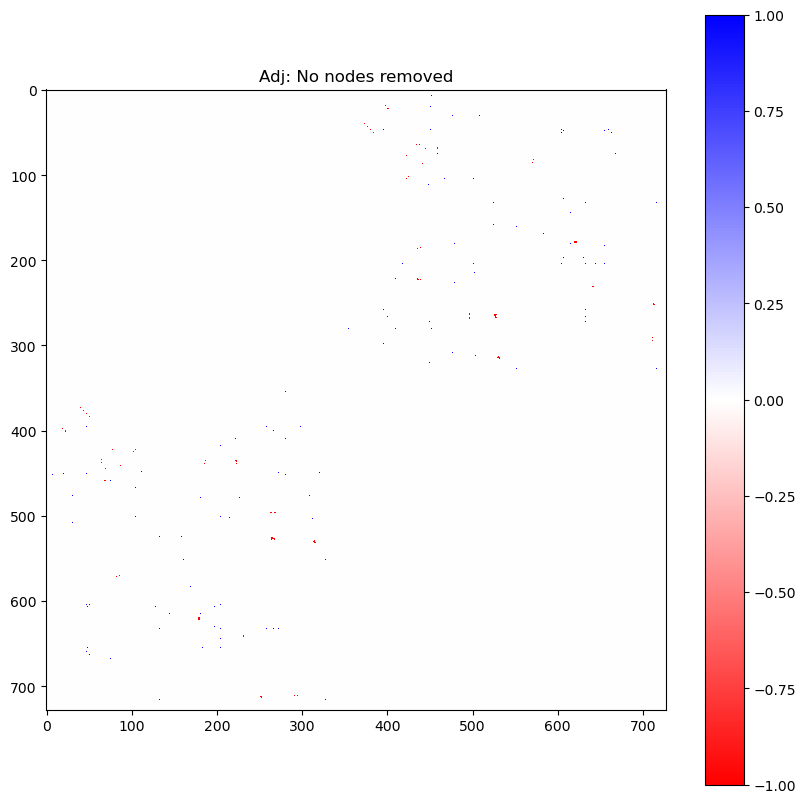

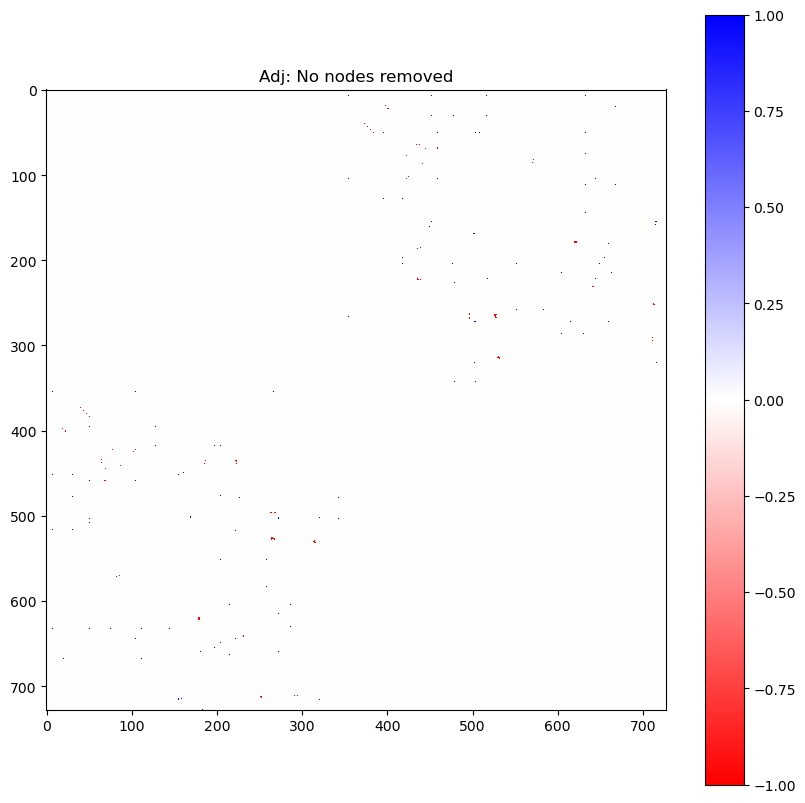

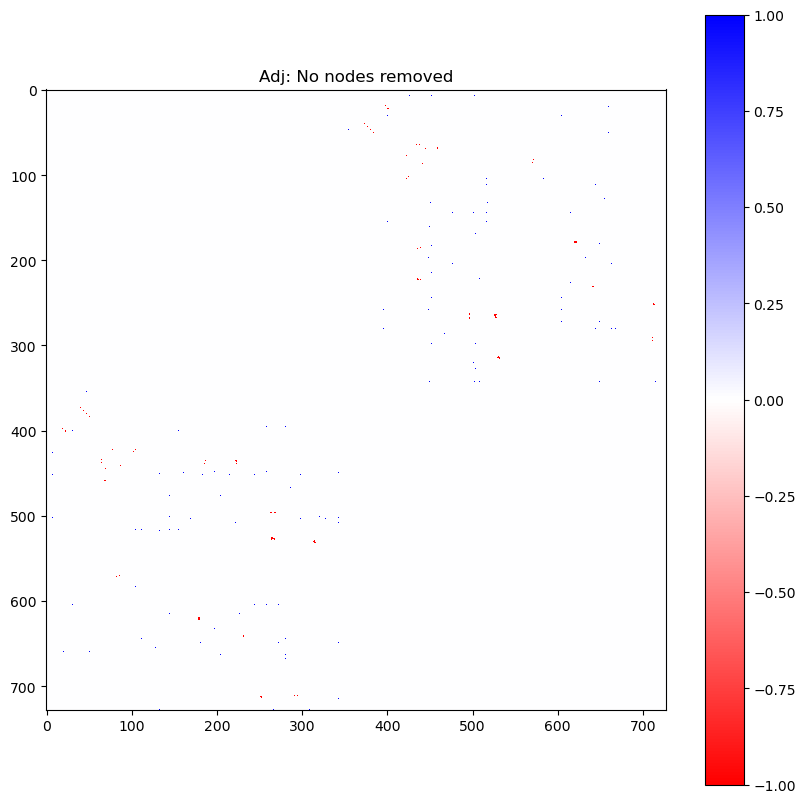

Trial 2 : gen rand graph with closest SP distri.
layer1InterRd [68, 291, 32, 130, 60, 253, 230, 241, 333, 194, 107, 48, 249, 14, 199, 221, 311, 1, 228, 136, 117, 302, 52, 162, 15, 11, 13, 332, 277, 4, 195, 351, 110, 216, 270, 113, 224, 283, 119, 176, 118, 346, 112, 235, 148, 213]
layer2InterRd [638, 682, 405, 449, 676, 724, 505, 415, 524, 723, 718, 610, 570, 613, 697, 451, 509, 499, 654, 609, 612, 555, 655, 371, 599, 478, 560, 566, 694, 442, 541, 634, 713, 699, 545, 398, 578, 693, 614, 409, 437, 620, 543]


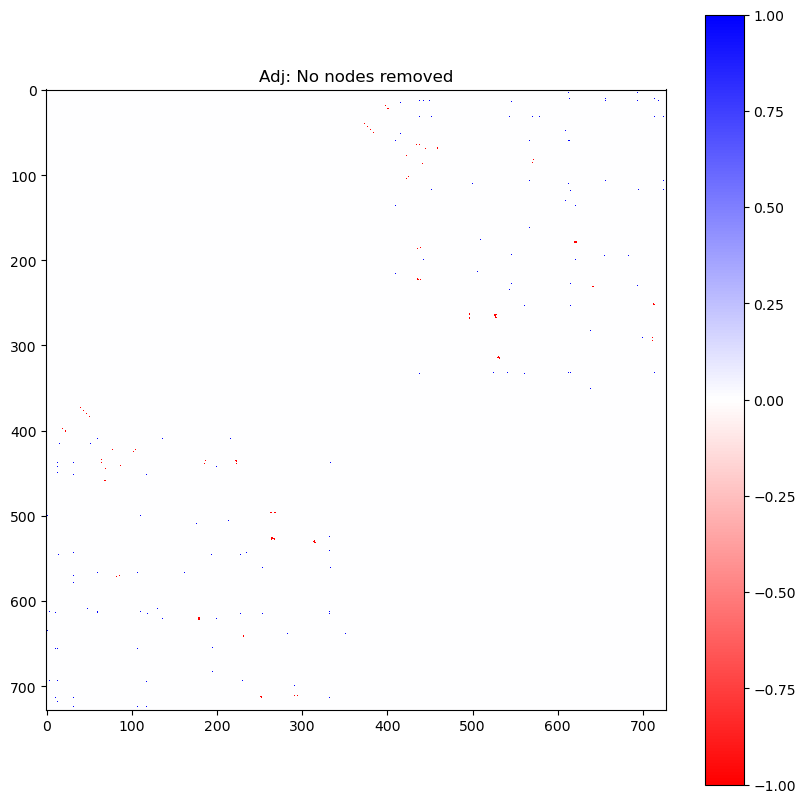

Trial 3 : gen rand graph with closest SP distri.
layer1InterRd [28, 46, 43, 184, 86, 342, 157, 128, 310, 108, 18, 297, 348, 81, 220, 326, 201, 260, 190, 278, 227, 257, 137, 14, 186, 238, 163, 194, 216, 269, 84, 286, 90, 120, 118, 12, 166, 88, 69, 261, 263, 345, 93, 228, 212, 268]
layer2InterRd [540, 657, 535, 539, 582, 436, 558, 720, 590, 689, 625, 481, 604, 496, 609, 610, 617, 692, 586, 533, 644, 725, 639, 724, 587, 603, 691, 467, 520, 712, 439, 669, 491, 599, 512, 509, 715, 612, 641, 619, 613, 687, 655]


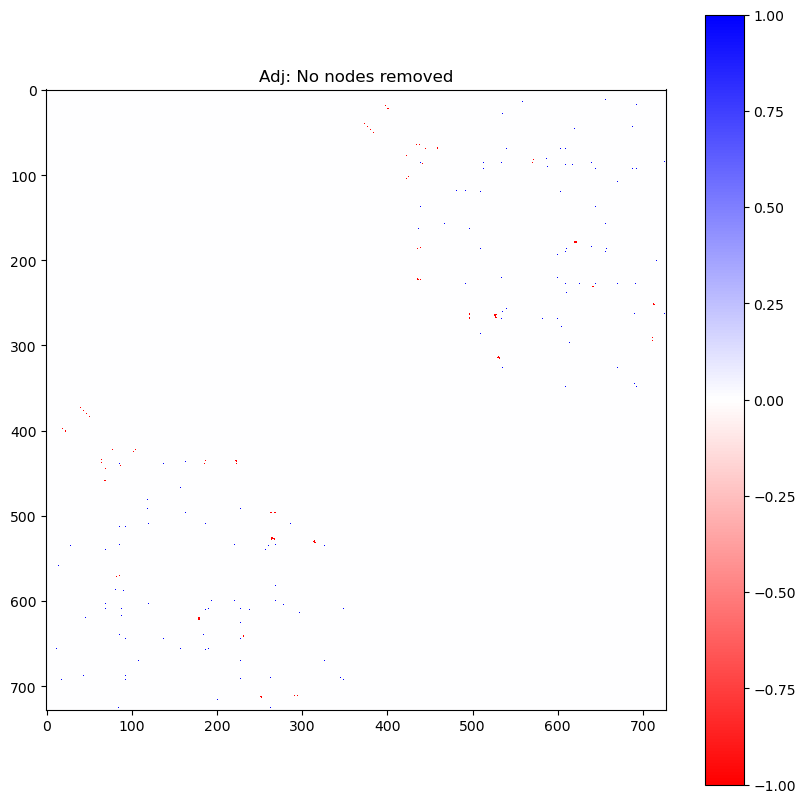

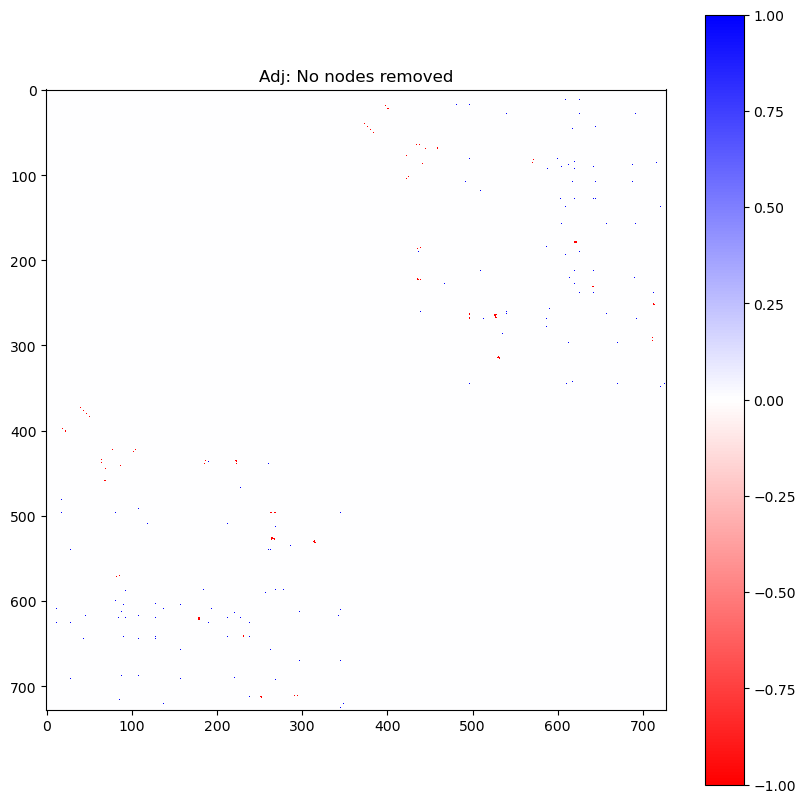

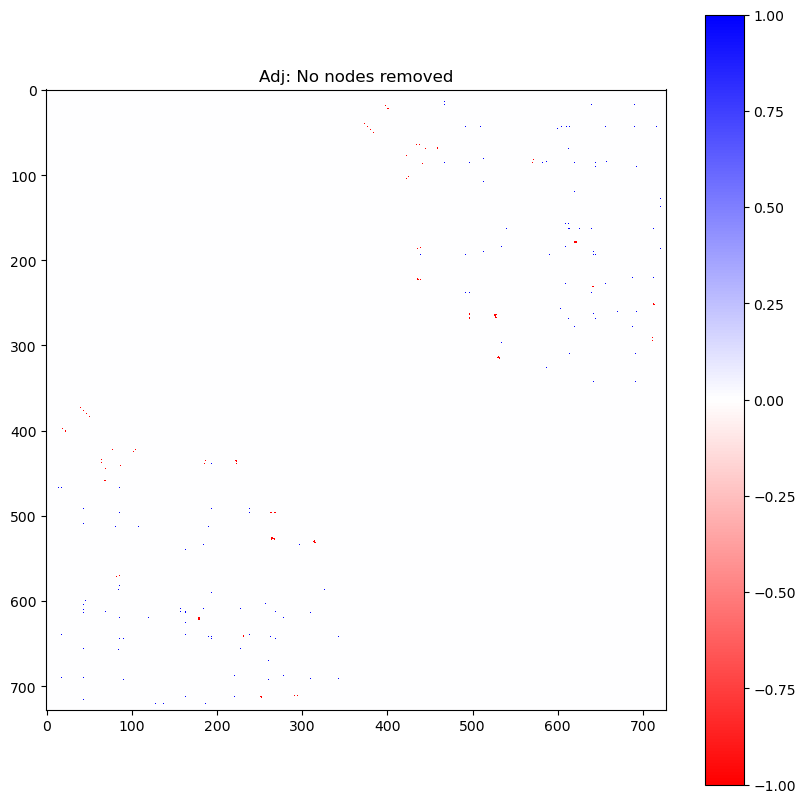

Trial 4 : gen rand graph with closest SP distri.
layer1InterRd [121, 303, 278, 66, 189, 309, 242, 320, 297, 33, 310, 6, 240, 132, 282, 119, 98, 276, 281, 243, 203, 327, 77, 118, 325, 267, 199, 7, 343, 32, 81, 302, 21, 154, 15, 137, 304, 198, 218, 202, 295, 227, 68, 187, 49, 18]
layer2InterRd [423, 607, 465, 486, 698, 577, 674, 508, 569, 613, 551, 647, 533, 627, 653, 562, 472, 526, 703, 368, 497, 664, 697, 710, 437, 711, 521, 631, 646, 645, 407, 719, 689, 462, 678, 490, 499, 417, 386, 600, 681, 601, 399]
Trial 5 : gen rand graph with closest SP distri.
layer1InterRd [120, 155, 52, 202, 245, 79, 46, 34, 10, 205, 281, 148, 30, 113, 266, 274, 184, 141, 88, 54, 134, 109, 13, 328, 133, 139, 99, 84, 158, 321, 190, 44, 310, 172, 343, 198, 259, 127, 91, 126, 242, 143, 45, 280, 153, 3]
layer2InterRd [503, 647, 714, 513, 614, 453, 565, 570, 660, 501, 574, 585, 436, 473, 510, 486, 376, 395, 377, 590, 674, 497, 619, 627, 685, 595, 712, 529, 428, 698, 454, 388, 457, 679, 677, 579, 495, 448, 536, 577

/tmp/ipykernel_785755/2919777786.py:149: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


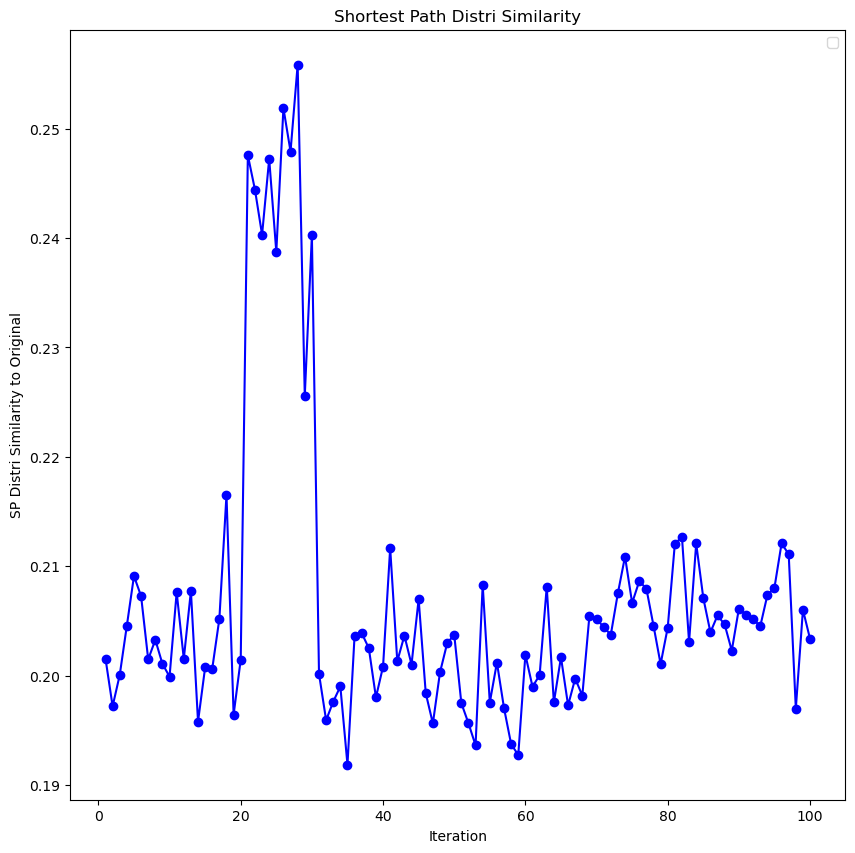

In [439]:
prot = Protein("data/fold_clock_bmal1_model_0.pdb", 7.)
g, layers = prot.getGraph()
l1, l2 = layers[0], layers[1]
print(g)
# rt = RandomTrials(10, g, layers)
# rt.plotMetrics()
ri = RandomInterlayer(g, layers)
# ri.plotAdj()
ri.genRandWithSP2(maxTrials=10, flag=1)
# nG1 = ri.getRand()
# print(nG1)
# nG2, nG3 = ri.getRandTopo()
# print(nG2)
# print(nG3)
# mc = MultiCens(nG3, layers, .9, 1000)
# m = mc.getMultiCens()
# print(m)
# e = nx.eigenvector_centrality(nG3, max_iter=1000, tol=1e-6)
# e = np.array([e[i] for i in range(l1+l2)])
# e = (e - e.min()) / (e.max() - e.min())
# # print(e)
# compareRankings(layers, nG3, e, m)
# remove = list(range(98,151))+list(range(196,224))
# remove = list(range(252,463))
# remove = list(range(466,505))+list(range(560,571))
# compareEVSpectrum(g, remove)
# compareAdj(g, remove)
# compareEVShifts(g, remove)